In [21]:
import pandas as pd

In [22]:
path = '/home/aiops/zhuty/tinyllama/scripts/fewshot_eval/results/rag_outputs_uoe.csv'
df = pd.read_csv(path)
df.head()

,Unnamed: 0,task,n_shot,seed,model,score,num_docs
0,0,nq_obqa,3,42,yuzhaouoe/BM25Chunk,19.972299,1
1,1,nq_obqa,3,43,yuzhaouoe/BM25Chunk,22.299169,1
2,2,nq_obqa,3,44,yuzhaouoe/BM25Chunk,18.393352,1
3,3,nq_obqa,3,45,yuzhaouoe/BM25Chunk,20.997230,1
4,4,nq_obqa,3,46,yuzhaouoe/BM25Chunk,18.919668,1


In [23]:
df

,Unnamed: 0,task,n_shot,seed,model,score,num_docs
0,0,nq_obqa,3,42,yuzhaouoe/BM25Chunk,19.972299,1
1,1,nq_obqa,3,43,yuzhaouoe/BM25Chunk,22.299169,1
2,2,nq_obqa,3,44,yuzhaouoe/BM25Chunk,18.393352,1
3,3,nq_obqa,3,45,yuzhaouoe/BM25Chunk,20.997230,1
4,4,nq_obqa,3,46,yuzhaouoe/BM25Chunk,18.919668,1
...,...,...,...,...,...,...,...
135,135,tq_obqa,3,42,yuzhaouoe/MixChunk,32.785291,5
136,136,tq_obqa,3,43,yuzhaouoe/MixChunk,37.708831,5
137,137,tq_obqa,3,44,yuzhaouoe/MixChunk,31.830637,5
138,138,tq_obqa,3,45,yuzhaouoe/MixChunk,34.712278,5


In [24]:
selected_task = 'tq_obqa'
df = df[df['task'] == selected_task]
df = df[df['num_docs'] <=10]
print(len(df))

60


In [25]:
def extract_pretrain_dataset(x):
    """
    Sample input: /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_cc_8k/iter-200000-ckpt-step-25000_hf
    Sample output: cc_8k
    Args:
        x:
    Returns:

    """
    if '/home/aiops/zhuty' in x:
        folder_name = x.split('/')[-2] # tiny_LLaMA_1b_8k_cc_8k
        return ("_").join(folder_name.split('_')[4:]) # cc_8k
    else:
        # sample model name: tyzhu/tiny_LLaMA_120M_8k_cc_8k_iter-240000-ckpt-step-60000_hf
        return x.strip("tyzhu/").split("_8k_")[1]

def extract_uoe_model(x):
    return x.split('/')[-1]

name_to_meaning_map = {"cc_8k": "random", "intramask_cc_8k": "intradoc", "cc_merged_v1_8k": "dense", "cc_merged_v2_8k": "bm25"}

# df['model'] = df['model'].apply(extract_pretrain_dataset)
# df['model'] = df['model'].map(name_to_meaning_map)
df['model'] = df['model'].apply(extract_uoe_model)

In [26]:
grouped_df = df.groupby(['model', 'task', 'num_docs' ]).agg({'score': ['mean', 'std']})

In [27]:
grouped_df

score          
                                 mean       std
model     task    num_docs                     
BM25Chunk tq_obqa 1         41.499160  1.214482
                  3         40.572792  3.093306
                  5         37.848493  2.413747
IntraDoc  tq_obqa 1         44.497481  0.373928
                  3         42.743746  1.446916
                  5         40.378326  1.035039
MixChunk  tq_obqa 1         39.393618  0.641163
                  3         37.309290  1.761429
                  5         34.337488  2.252663
UniChunk  tq_obqa 1         40.003536  1.722690
                  3         36.821356  3.149562
                  5         37.307522  1.086141

In [28]:
# visualize as a line plot
import matplotlib.pyplot as plt
import seaborn as sns

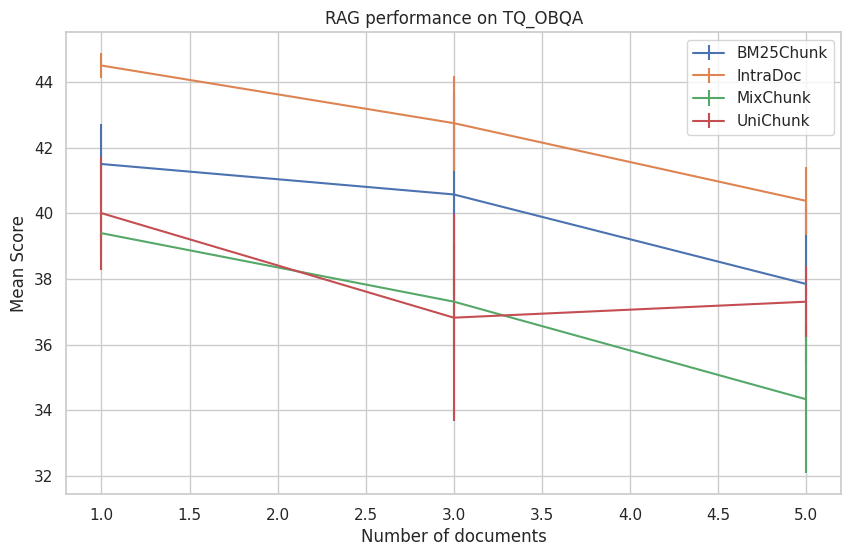

In [29]:

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
# plot the mean and the standard deviation
for model in grouped_df.index.get_level_values(0).unique():
    for task in grouped_df.index.get_level_values(1).unique():
        df_to_plot = grouped_df.loc[(model, task)]
        plt.errorbar(df_to_plot.index.get_level_values(0), df_to_plot['score']['mean'], yerr=df_to_plot['score']['std'], label=model)
plt.title('RAG performance on {}'.format(selected_task.upper()))
plt.ylabel('Mean Score')
plt.xlabel('Number of documents')
plt.legend()
plt.show()